# Exploration

In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime  as dt

In [167]:
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline
sns.set()

In [168]:
# load the datasets
train = pd.read_csv("train.csv", parse_dates=['Date'],date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))
store_info = pd.read_csv("store.csv",header=0)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [169]:
# check columns of the datasets
print(train.columns.values)
print(store_info.columns.values)
# check head of datasets
print(train.head)
print(store_info.tail)

['Store' 'DayOfWeek' 'Date' 'Sales' 'Customers' 'Open' 'Promo'
 'StateHoliday' 'SchoolHoliday']
['Store' 'StoreType' 'Assortment' 'CompetitionDistance'
 'CompetitionOpenSinceMonth' 'CompetitionOpenSinceYear' 'Promo2'
 'Promo2SinceWeek' 'Promo2SinceYear' 'PromoInterval']
<bound method NDFrame.head of          Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1            2          5 2015-07-31   6064        625     1      1   
2            3          5 2015-07-31   8314        821     1      1   
3            4          5 2015-07-31  13995       1498     1      1   
4            5          5 2015-07-31   4822        559     1      1   
5            6          5 2015-07-31   5651        589     1      1   
6            7          5 2015-07-31  15344       1414     1      1   
7            8          5 2015-07-31   8492        833     1      1   
8            9          5 2015-07-31   8565        687     1

In [170]:
# check for missing / NAN values
print(train.isnull().values.any())
print(store_info.isnull().values.any())

# focus on store_info to handle missing values
for column in store_info.columns.values:
    print(str(column)+": "+ str(store_info.loc[:,column].isnull().values.any()))

False
True
Store: False
StoreType: False
Assortment: False
CompetitionDistance: True
CompetitionOpenSinceMonth: True
CompetitionOpenSinceYear: True
Promo2: False
Promo2SinceWeek: True
Promo2SinceYear: True
PromoInterval: True


In [171]:
# For the competition variables, I will consider NaN to be an absence of the information 
# For the promo variables, NaN means simply the absence of promotion 2 (Prom2=0)
print(store_info.loc[store_info["Promo2"]==0,["Promo2SinceWeek","Promo2SinceYear","PromoInterval"]])

      Promo2SinceWeek  Promo2SinceYear PromoInterval
0                 NaN              NaN           NaN
3                 NaN              NaN           NaN
4                 NaN              NaN           NaN
5                 NaN              NaN           NaN
6                 NaN              NaN           NaN
7                 NaN              NaN           NaN
8                 NaN              NaN           NaN
9                 NaN              NaN           NaN
15                NaN              NaN           NaN
22                NaN              NaN           NaN
24                NaN              NaN           NaN
25                NaN              NaN           NaN
28                NaN              NaN           NaN
30                NaN              NaN           NaN
32                NaN              NaN           NaN
33                NaN              NaN           NaN
36                NaN              NaN           NaN
37                NaN              NaN        

In [172]:
# Set Date column as index
train.set_index(train.Date,inplace=True)

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0, 0.5, 'Total Sales'), Text(0.5, 0, 'Months')]

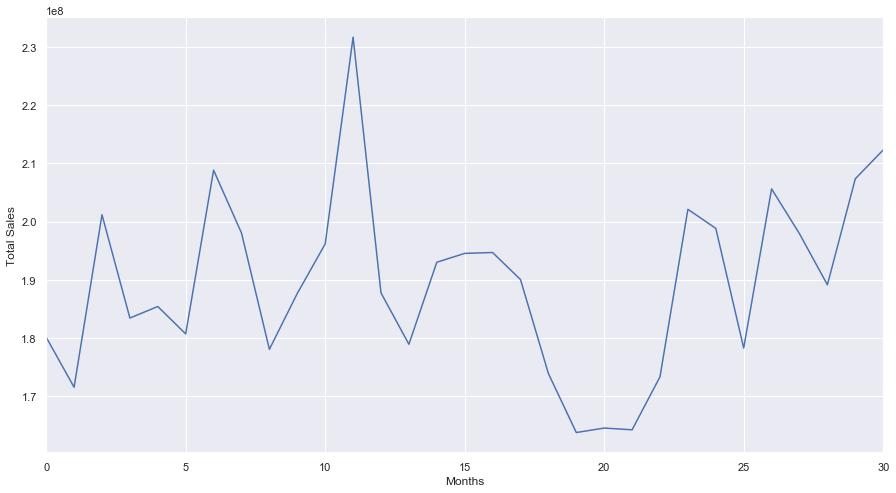

In [173]:
# Plot monthly total sales 
# we can see some seasonal patterns which should be taken into account in our alerting system
# potential issues around months 19, 20 and 21
total_sales_per_month = train.groupby(pd.Grouper(freq="M")).apply(lambda x: np.sum(x.Sales))
plt.figure(figsize=(15,8))
fig = sns.tsplot(total_sales_per_month)
fig.set(xlabel = 'Months', ylabel='Total Sales')

# Define Store categories

We do not have enough data (only 2.5 years) to have a clear idea of the possible deviation of sales within years for a specifc store and at a specific date. So I decided to categorize the stores based on some below features. Then, I aim at computing the standard deviation of sales for each category. At last, the "confidence interval" for a specific store (= the sales range of one store ) will be:  
[-STD of its category + 2-year sales average of the store ; STD of its category + 2-year sales average]

In [174]:
# compute total sales per store
total_sales_per_store = train.groupby(by=["Store"]).apply(lambda x: (np.sum(x.Sales)))
total_sales_per_store = pd.DataFrame(total_sales_per_store)
total_sales_per_store.index = pd.RangeIndex(start=0, stop=1115, step=1)
# merge store_info and total sales per store
new_store_info = pd.merge(left = store_info, right = total_sales_per_store, left_index=True, right_index=True)
new_store_info.columns.values[10] = 'TotalSales'


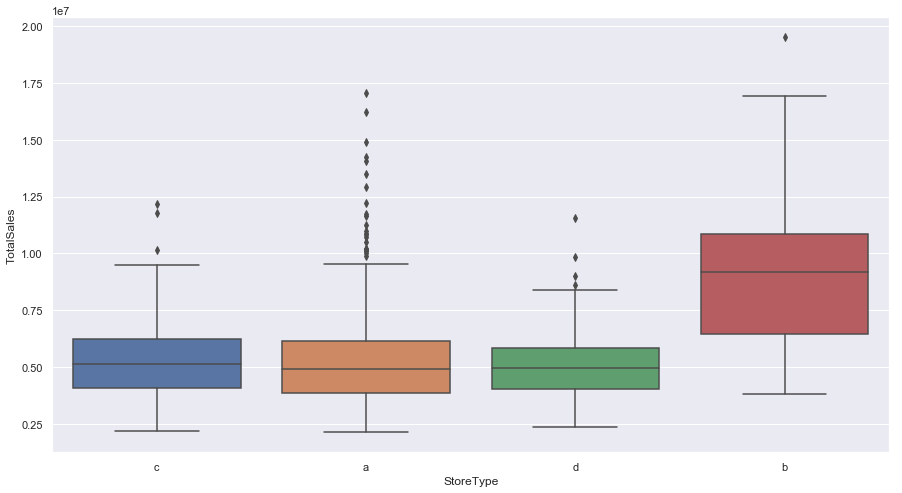

In [175]:
# Plot total sales versus store type
# Store Type b has a significantly higher average total sales. It should be part of the our distinction.
plt.figure(figsize=(15,8))
sns.boxplot(data=new_store_info, x='StoreType', y='TotalSales')
plt.show()

# Create a dummy variable type_b or not
dummies = pd.get_dummies(new_store_info.StoreType)
new_store_info["type_b"] = dummies["b"]

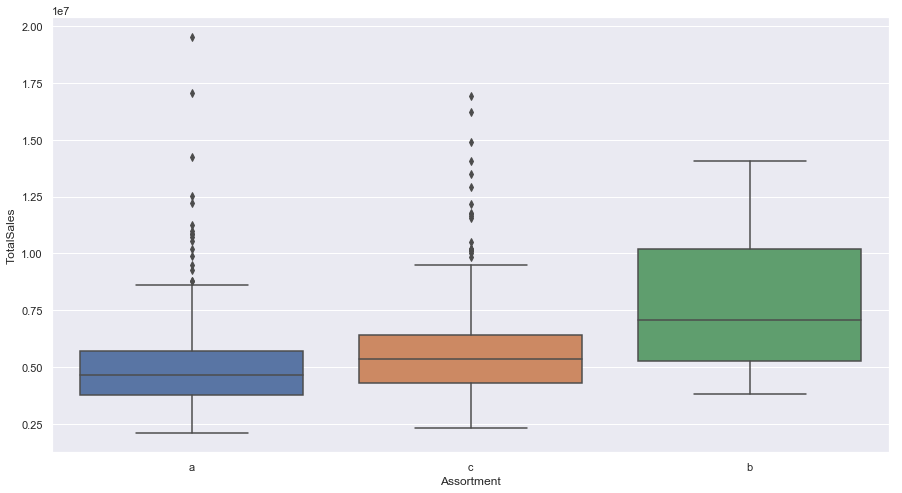

In [176]:
# Plot total sales versus Assortment
# The 3 types of assortments have significantly different average total sales. It should be part our distinction.
plt.figure(figsize=(15,8))
sns.boxplot(data=new_store_info, x='Assortment', y='TotalSales')
plt.show()

# Create dummy variables 
dummies = pd.get_dummies(new_store_info.Assortment)
new_store_info["assortment_a"] = dummies["a"]
new_store_info["assortment_b"] = dummies["b"]
new_store_info["assortment_c"] = dummies["c"]

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


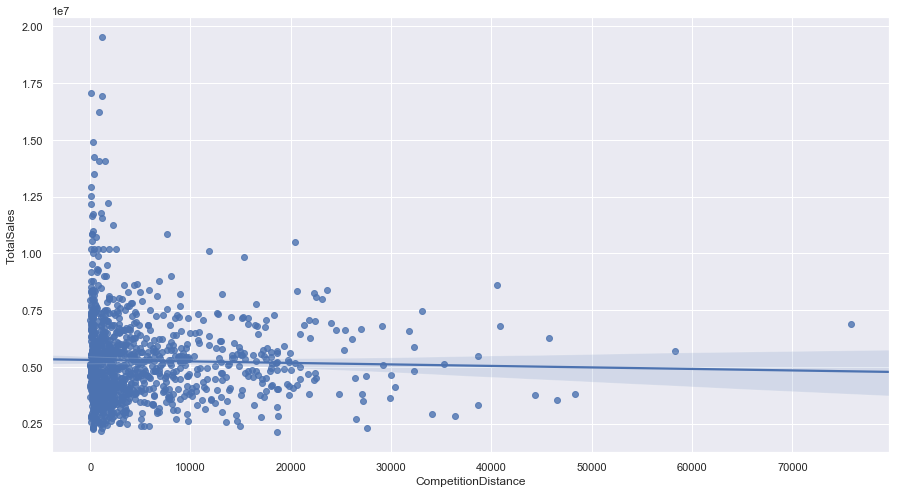

In [177]:
# plot competition distance versus total sales
# no obvious link / no time to investigate more
plt.figure(figsize=(15,8))
sns.regplot(data=new_store_info, x='CompetitionDistance', y='TotalSales')
plt.show()

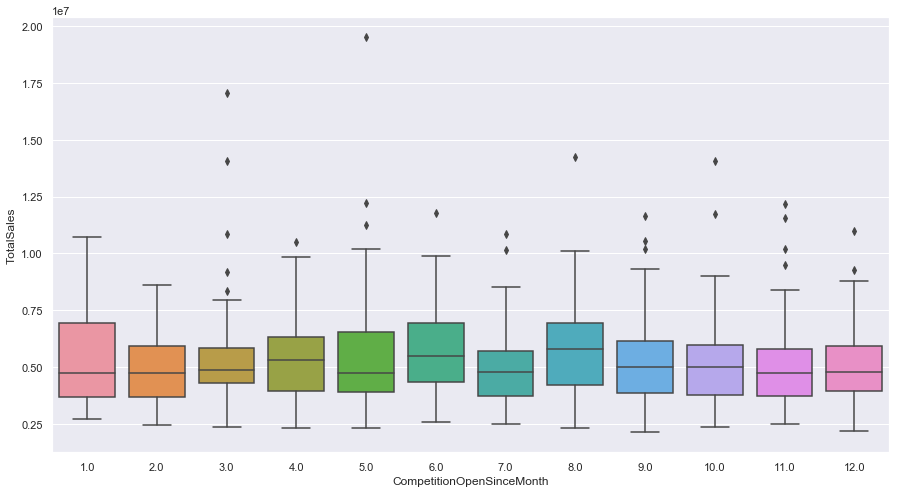

In [178]:
# Plot total sales versus Competition Open Since Month
# no obvious link / no time to investigate more
new_store_info.CompetitionOpenSinceMonth.astype('category')
plt.figure(figsize=(15,8))
sns.boxplot(data=new_store_info, x='CompetitionOpenSinceMonth', y='TotalSales')
plt.show()

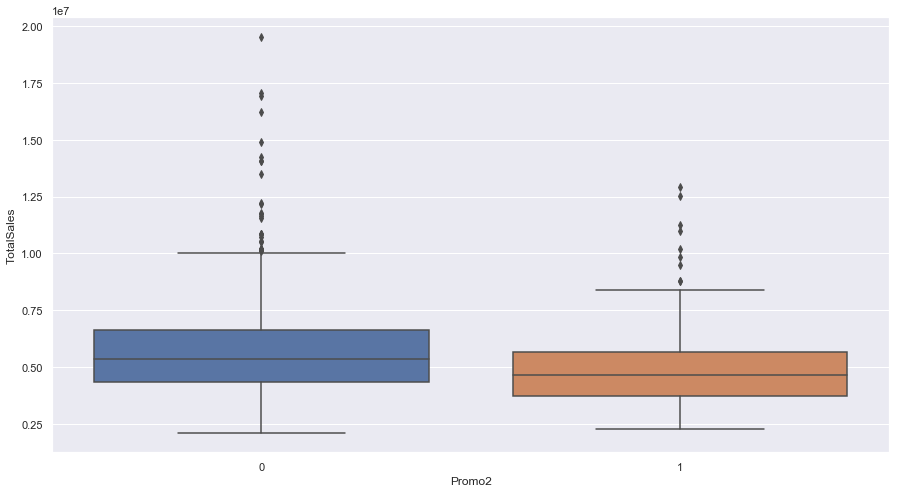

In [179]:
# Plot total sales versus Promo2
# Stores without Promo2 have significantly higher total sales. It should be part of the our distinction.

plt.figure(figsize=(15,8))
sns.boxplot(data=new_store_info, x='Promo2', y='TotalSales')
plt.show()


Conclusion: the stores will be split depending on Type_b (store_type_b), Assortment_a, Assortment_b, Assortment_C and Promo2.

In [180]:
# Define the different categories

# Assortment A
category_1 = 1 # Assortment A, Type_b = 1 and Promo2 = 1
category_2 = 2 # Assortment A, Type_b = 0 and Promo2 = 1
category_3 = 3 # Assortment A, Type_b = 0 and Promo2 = 0
category_4 = 4 # Assortment A, Type_b = 1 and Promo2 = 0
 
# Assortment B
category_5 = 5 # Assortment B, Type_b = 1 and Promo2 = 1
category_6 = 6 # Assortment B, Type_b = 0 and Promo2 = 1
category_7 = 7 # Assortment B, Type_b = 0 and Promo2 = 0
category_8 = 8 # Assortment B, Type_b = 1 and Promo2 = 0

# Assortment C
category_9 = 9 # Assortment C, Type_b = 1 and Promo2 = 1
category_10 = 10 # Assortment C, Type_b = 0 and Promo2 = 1
category_11 = 11 # Assortment C, Type_b = 0 and Promo2 = 0
category_12 = 12 # Assortment C, Type_b = 1 and Promo2 = 0

# Function that returns the category of a specific store

def define_category(store):

    assortment = new_store_info.loc[new_store_info.Store==store,"Assortment"]

    if assortment.item()=="a":
        categories = [1,2,3,4]
    elif assortment.item()=="b":
        categories = [5,6,7,8]
    else:
        categories = [9,10,11,12]
    
    if new_store_info.loc[new_store_info.Store==store,"type_b"].item()==1:
        if new_store_info.loc[new_store_info.Store==store,"Promo2"].item()==1:
            #Type_b = 1 & Promo2 = 1
            return categories[0]
        else:
            # Type_b = 1 & Promo2 = 0
            return categories[3]
    else:
        if new_store_info.loc[new_store_info.Store==store,"Promo2"].item()==1:
             #Type_b = 0 & Promo2 = 1
            return categories[1]
        else:
            # Type_b = 0 & Promo2 = 0
            return categories[2]
    

In [181]:
# Create the column final category giving the category of each store
for store in new_store_info.loc[:,"Store"]:
    new_store_info.loc[new_store_info.Store ==store,"final_category"]=define_category(store)

In [182]:
# Change final_category type
new_store_info.final_category=new_store_info.final_category.apply(int)

In [183]:
# Check the relevancy of each category
# Only 4 of them appears to make sense and can be used to compute an alerting system.
# For the other small categories, we can grouped them under the category "Store Type b" ()
for i in range(1,13):
    print(np.sum(new_store_info.final_category==i))

1
303
283
6
4
0
0
5
0
263
249
1


Conclusion: Perform the alerting system on the following clusters:
- category 2: Assortment A, Type_b = 0 and Promo2 = 1
- category 3: Assortment A, Type_b = 0 and Promo2 = 0
- category 10: Assortment C, Type_b = 0 and Promo2 = 1
- category 11: Assortment C, Type_b = 0 and Promo2 = 0
- a new category: Type_b = 1

# Alerting Sytem

Not enough time to complete this part...

Remaining steps:

1. Compute the std of each of the 5 remaining categories for a specific day

2. Build a function that:
    - takes a store as input and a day
    - compute its average sales over the last 2 years for each day (to take into account seasonality)
    - return a 'confidence interval': [store average sales +/- std of its category for this specific day]
    
3. Create a monitoring function to check if the actual sales are in the confidence interval